# 0. Data Load
---

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import warnings
from matplotlib import pyplot as plt

warnings.simplefilter('ignore')

def row_num(x): return pd.set_option('display.max_rows',x)
def col_num(x): return pd.set_option('display.max_columns',x)

row_num(10)
col_num(10)

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_ogwr = pd.read_csv('../../1_preprocessing/정제데이터/MGWR회귀계수/MGWR 회귀계수(평균영업기간,mm,data_1221).csv', encoding='euc-kr')
df_cgwr = pd.read_csv('../../1_preprocessing/정제데이터/MGWR회귀계수/MGWR 회귀계수(평균폐업기간,mm,expo,data_1222).csv', encoding='euc-kr')
df_ready = pd.read_csv('../../1_preprocessing/정제데이터/ready_dataset.csv', encoding='euc-kr')
gdf_bp = gpd.read_file('../shp_모음/부평구_기초구역_4326.shp', encoding='euc-kr')

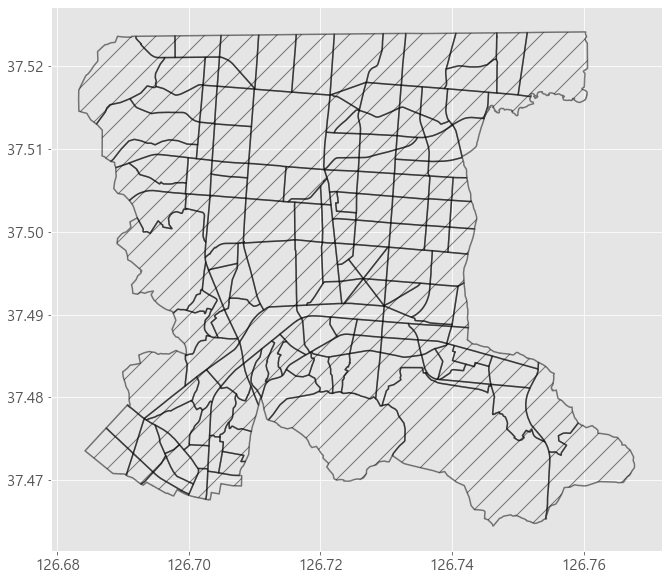

In [3]:
gdf_bp.boundary.plot(color='black', alpha=.5, hatch='/')
plt.show()

In [57]:
# df_ogwr.info()

In [58]:
# df_cgwr.info()

In [59]:
# df_ready.info()

# 1. 군집화 모델 구성

- model : AgglomerativeClustering
- metric : `Cosine`
- affinity : `Average`
- n_cluster = 7, 9, 11, 13, 15
- 스케일링 있는 군집 // 없는 군집화로 나누어 수행

## 1.1. 스케일링하지 않은 군집

In [4]:
# 계층 군집화 수행
from sklearn.cluster import AgglomerativeClustering as AGG

o_store_cluster = pd.DataFrame(df_ogwr['BAS_ID'].astype(str))
c_store_cluster = pd.DataFrame(df_cgwr['BAS_ID'].astype(str))
    
for i in range(7,31):
    open_agcluster = AGG(n_clusters=i, linkage='average', affinity='cosine').fit(df_ogwr.drop(['BAS_ID','x','y'],axis=1))
    o_cluster = open_agcluster.labels_
    col_name = 'open_'+str(i)+'cluster'
    o_store_cluster[col_name] = o_cluster
    
for i in range(7,31):
    close_agcluster = AGG(n_clusters=i, linkage='average', affinity='cosine').fit(df_cgwr.drop(['BAS_ID','x','y'],axis=1))
    c_cluster = close_agcluster.labels_
    col_name = 'close_'+str(i)+'cluster'
    c_store_cluster[col_name] = c_cluster

In [5]:
std_num='15'
o_std_col = 'open_'+std_num+'cluster'
c_std_col = 'close_'+std_num+'cluster'
o_cgpd = pd.merge(gdf_bp, o_store_cluster[['BAS_ID',o_std_col]], on='BAS_ID', how='left')
c_cgpd = pd.merge(gdf_bp, c_store_cluster[['BAS_ID',c_std_col]], on='BAS_ID', how='left')
# c_cgpd.info()

o_cgpd['BAS_ID'] = o_cgpd['BAS_ID'].astype(int)
c_cgpd['BAS_ID'] = c_cgpd['BAS_ID'].astype(int)

o_cgpd = pd.merge(o_cgpd, df_ogwr[['BAS_ID','x','y']], on='BAS_ID', how = 'left')
c_cgpd = pd.merge(c_cgpd, df_cgwr[['BAS_ID','x','y']], on='BAS_ID', how = 'left')

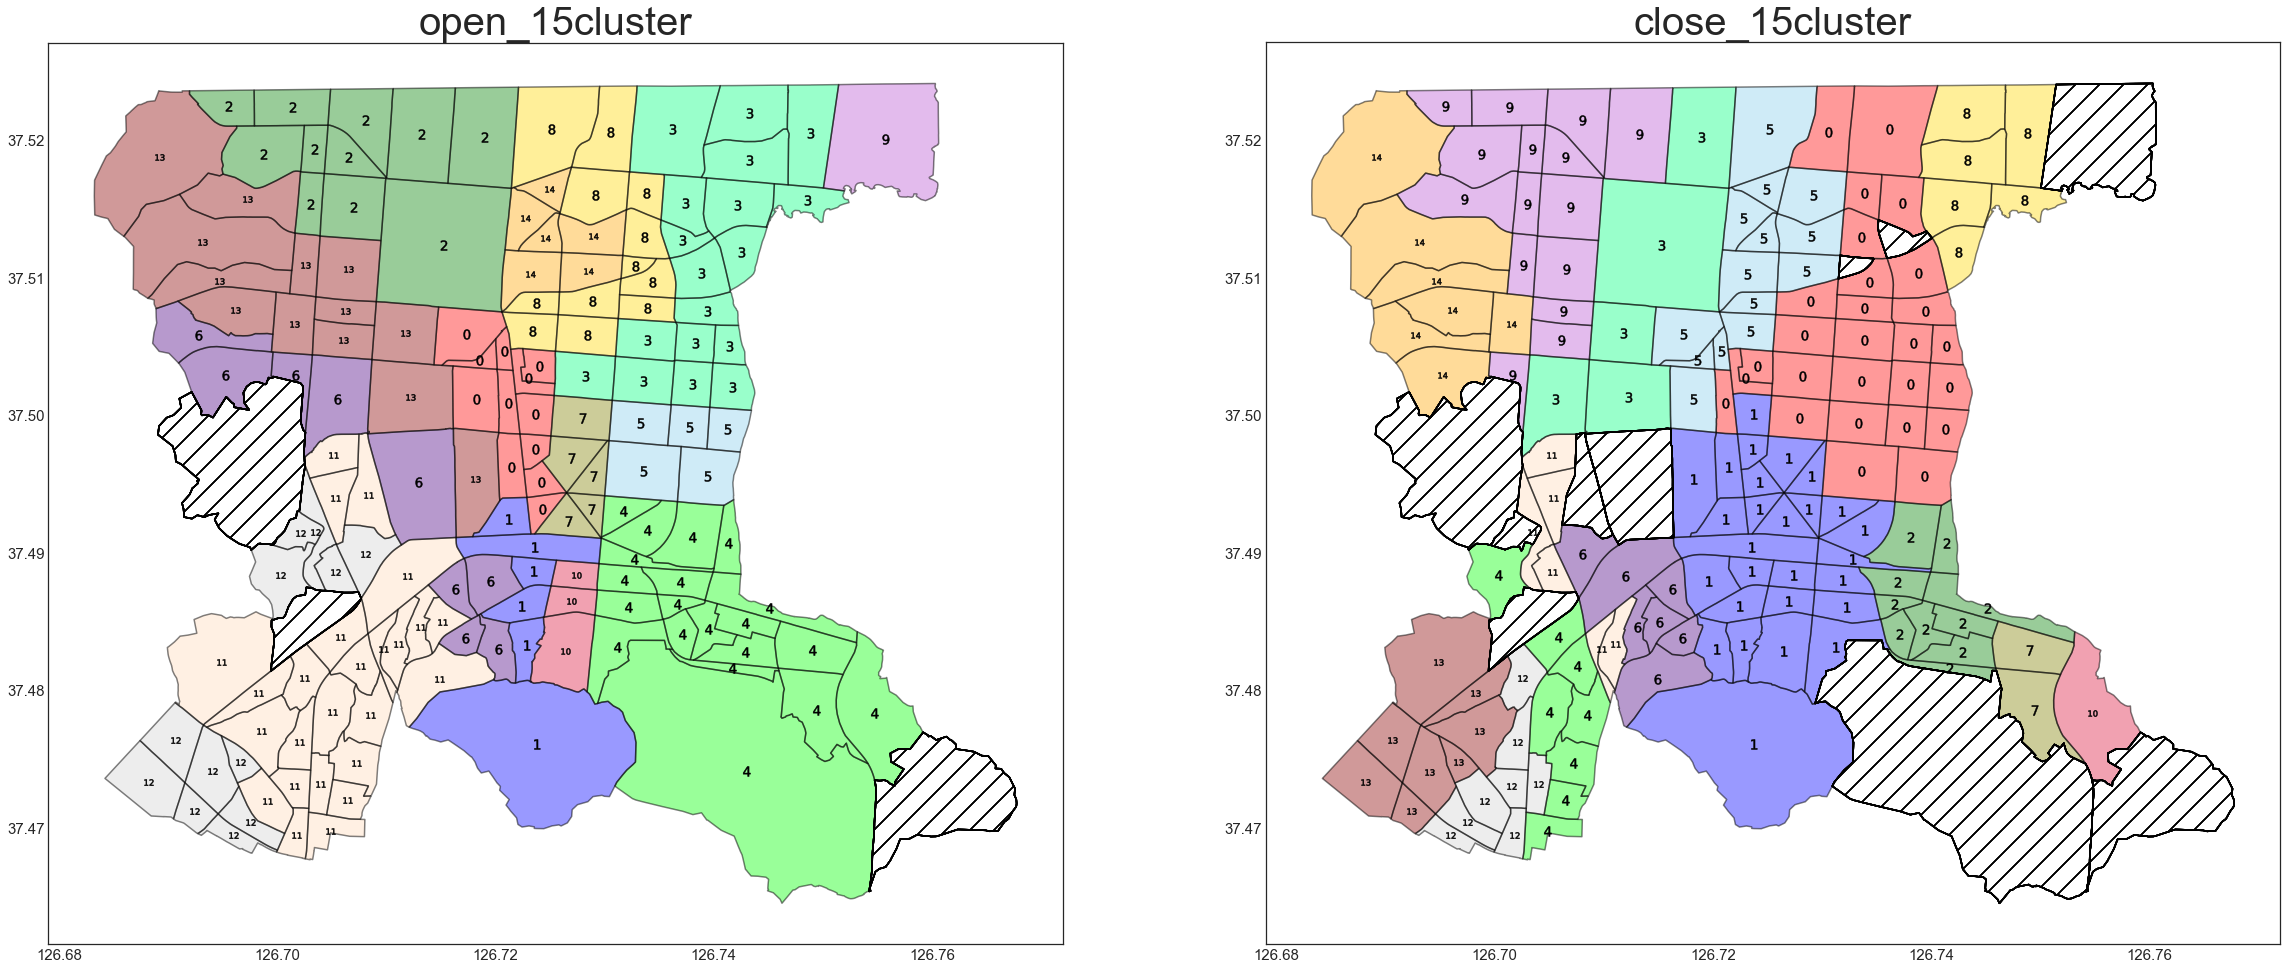

In [18]:
plt.style.use('seaborn-white')

color_list = ['red','blue','green','springgreen','lime',
              'skyblue','indigo','olive','gold','mediumorchid',
              'crimson','peachpuff','lightgrey','darkred','orange']
fig, ax = plt.subplots(1,2,figsize=(40,20))
o_cgpd.boundary.plot(axes=ax[0],color='black', alpha=.5)
for cls_num, c in zip(range(0,int(std_num)), color_list):
    o_cgpd.loc[o_cgpd[o_std_col]==cls_num].plot(axes=ax[0], color=c,alpha=.4, label=str(cls_num))
    ax[0].scatter(o_cgpd.loc[o_cgpd[o_std_col]==cls_num]['x'],
                  o_cgpd.loc[o_cgpd[o_std_col]==cls_num]['y'], 
                  marker=f"${cls_num}$",s=100, c='black')
    o_cgpd.loc[o_cgpd[o_std_col].isna()].boundary.plot(axes=ax[0],color='black', alpha=.5, hatch='/')
    ax[0].set_title(o_std_col, size=40)
    
c_cgpd.boundary.plot(axes=ax[1],color='black', alpha=.5)
for cls_num, c in zip(range(0,int(std_num)), color_list):
    c_cgpd.loc[c_cgpd[c_std_col]==cls_num].plot(axes=ax[1], color=c,alpha=.4, label=cls_num)
    ax[1].scatter(c_cgpd.loc[c_cgpd[c_std_col]==cls_num]['x'],
                  c_cgpd.loc[c_cgpd[c_std_col]==cls_num]['y'], 
                  marker=f"${cls_num}$",s=100, c='black')
    c_cgpd.loc[c_cgpd[c_std_col].isna()].boundary.plot(axes=ax[1],color='black', alpha=.5, hatch='/')
    ax[1].set_title(c_std_col, size=40)

In [7]:
store_cluster = pd.merge(o_store_cluster, c_store_cluster, on='BAS_ID', how='left')

In [13]:
for i in range(0,15):
    cls_info = list(store_cluster.loc[store_cluster['close_15cluster']==i]['BAS_ID'].astype(int).values)
    print(f"{i} : {cls_info} :: {len(cls_info)}")

0 : [21317, 21318, 21323, 21324, 21328, 21337, 21340, 21341, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21350, 21351, 21352, 21353, 21355, 21356, 21357, 21358, 21360, 21379, 21397, 21398] :: 27
1 : [21359, 21387, 21388, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21399, 21400, 21403, 21404, 21406, 21407, 21408, 21414, 21424, 21425, 21426, 21429, 21430, 21431, 21456, 21458] :: 27
2 : [21401, 21402, 21415, 21416, 21419, 21420, 21421, 21422, 21423, 21427] :: 10
3 : [21315, 21334, 21363, 21376, 21377] :: 5
4 : [21374, 21433, 21434, 21435, 21436, 21438, 21439, 21440] :: 8
5 : [21316, 21329, 21330, 21331, 21332, 21333, 21335, 21336, 21338, 21354, 21364, 21365, 21366, 21378] :: 14
6 : [21384, 21405, 21409, 21410, 21411, 21428, 21432] :: 7
7 : [21418, 21457] :: 2
8 : [21319, 21320, 21321, 21325, 21326, 21342] :: 6
9 : [21301, 21302, 21303, 21304, 21305, 21306, 21309, 21310, 21311, 21312, 21313, 21314, 21361, 21362, 21370] :: 15
10 : [21417] :: 1
11 : [21380, 21382, 21383, 213

In [107]:
# store_cluster.to_csv('./군집화결과/12_4주차/f2_expo(total,mm,1222)).csv', index= False)

## 1.2. 스케일링 후 군집화

### 1.2.1 Min Max Scaler

In [8]:
# 영업, 폐업 스케일링
from sklearn.preprocessing import MinMaxScaler as MMS

df_osgwr = pd.DataFrame(MMS().fit_transform(df_ogwr.drop(['BAS_ID','x','y'], axis=1)), columns=df_ogwr.columns[:-3])
df_csgwr = pd.DataFrame(MMS().fit_transform(df_cgwr.drop(['BAS_ID','x','y'], axis=1)), columns=df_cgwr.columns[:-3])

o_mms_cluster = pd.DataFrame(df_ogwr['BAS_ID'])
c_mms_cluster = pd.DataFrame(df_cgwr['BAS_ID'])
    
for i in range(7,17,2):
    oscale_agcluster = AGG(n_clusters=i).fit(df_osgwr)
    os_cluster = oscale_agcluster.labels_
    col_name = 'open_'+str(i)+'cluster_mms'
    o_mms_cluster[col_name] = os_cluster
    
for i in range(7,17,2):
    cscale_agcluster = AGG(n_clusters=i).fit(df_csgwr)
    cs_cluster = cscale_agcluster.labels_
    col_name = 'close_'+str(i)+'cluster_mms'
    c_mms_cluster[col_name] = cs_cluster

In [9]:
mms_cluster = pd.merge(o_mms_cluster, c_mms_cluster, on='BAS_ID', how='left')

### 1.2.2. Standard Scaler

In [11]:
df_ogwr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   intercept            158 non-null    float64
 1   BAS_AR               158 non-null    float64
 2   도로길이고려_전체통합도         158 non-null    float64
 3   도로길이고려_국부통합도_R3      158 non-null    float64
 4   기초구역평균_전체통합도         158 non-null    float64
 5   기초구역평균_국부통합도_R3      158 non-null    float64
 6   도로율                  158 non-null    float64
 7   평균 도로 길이             158 non-null    float64
 8   아파트시세변화_차분평균         158 non-null    float64
 9   평균최근접역거리             158 non-null    float64
 10  평균최근접정류장거리           158 non-null    float64
 11  건물노후도                158 non-null    float64
 12  공동주택 연면적 비율          158 non-null    float64
 13  근린생활시설 연면적 비율        158 non-null    float64
 14  단독주택 연면적 비율          158 non-null    float64
 15  아파트 가구수              158 non-null    flo

#### 1.2.2.3. 표준정규화 (Std Scaler)

In [21]:
from sklearn.preprocessing import StandardScaler as SDS

df_osgwr = pd.DataFrame(SDS().fit_transform(df_ogwr.drop(['BAS_ID','x','y'], axis=1)), columns=df_ogwr.columns[:-3])
df_csgwr = pd.DataFrame(SDS().fit_transform(df_cgwr.drop(['BAS_ID','x','y'], axis=1)), columns=df_cgwr.columns[:-3])

o_sds_cluster = pd.DataFrame(df_ogwr['BAS_ID'])
c_sds_cluster = pd.DataFrame(df_cgwr['BAS_ID'])
    
for i in range(7,17,2):
    oscale_agcluster = AGG(n_clusters=i).fit(df_osgwr)
    os_cluster = oscale_agcluster.labels_
    col_name = 'open_'+str(i)+'cluster_sds'
    o_sds_cluster[col_name] = os_cluster
    
for i in range(7,17,2):
    cscale_agcluster = AGG(n_clusters=i).fit(df_csgwr)
    cs_cluster = cscale_agcluster.labels_
    col_name = 'close_'+str(i)+'cluster_sds'
    c_sds_cluster[col_name] = cs_cluster

In [22]:
sds_cluster = pd.merge(o_sds_cluster, c_sds_cluster, on='BAS_ID', how='left')

# 2. 회귀 계수 클러스터 별 시각화

In [16]:
# 좌표 달아주기
store_cluster = store_cluster.merge(df_ogwr[['BAS_ID','x','y']], on='BAS_ID', how='left')
mms_cluster = mms_cluster.merge(df_ogwr[['BAS_ID','x','y']], on='BAS_ID', how='left')
sds_cluster = sds_cluster.merge(df_ogwr[['BAS_ID','x','y']], on='BAS_ID', how='left')

## 2.1. 스케일링하지 않은 군집 시각화

In [ ]:
# cluster_list = [7,9,11,13]
color_list = ['red','blue','green','purple','grey','black','pink','yellow',
              'coral','olive','aqua','palegreen','darkorange','gold','lime']
def iter_num(value):
    if value%5==1: return 7
    elif value%5==2: return 9
    elif value%5==3: return 11
    elif value%5==4: return 13
    elif value%5==0: return 15
    else: None

for i in range(1,11):
    col_name = store_cluster.iloc[:,i].name 
    plt.title(col_name)
    for j in range(0,iter_num(i)):
        temp = store_cluster.loc[store_cluster[col_name]==j]
        plt.scatter(temp['x'],temp['y'],color=color_list[j],label=str(j)+'군집')
    plt.legend()
    plt.show()

## 2.2. Min-Max 스케일 군집 시각화

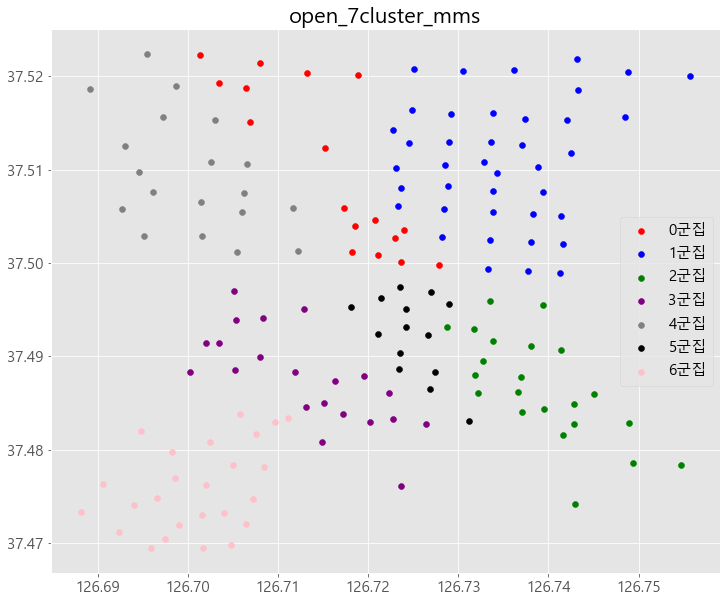

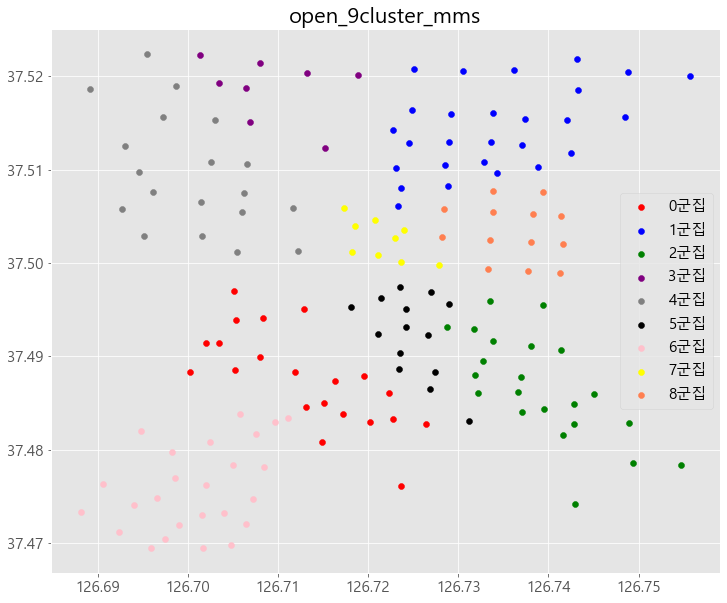

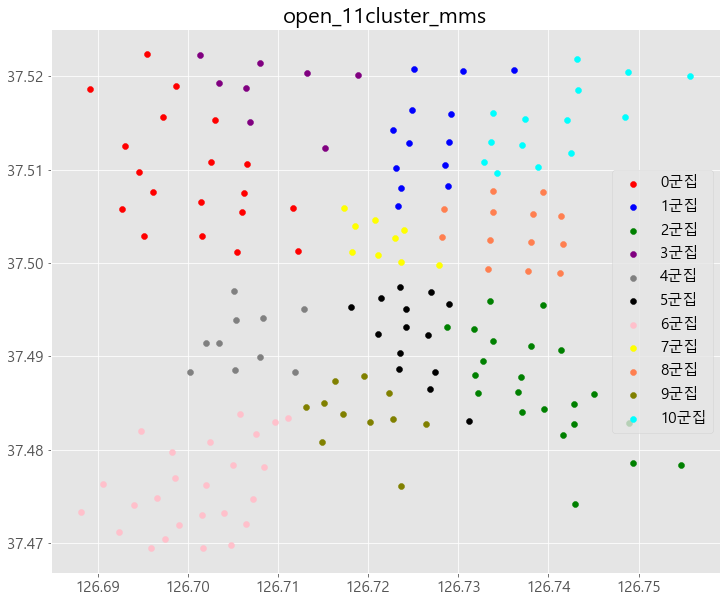

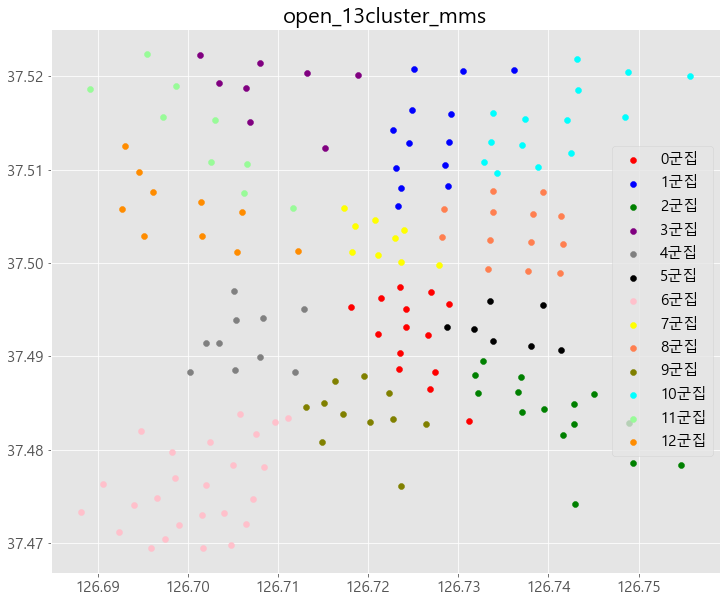

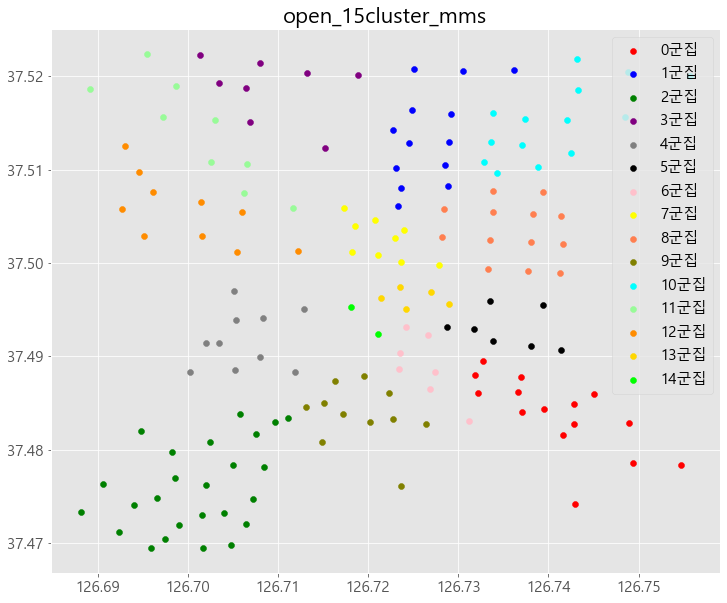

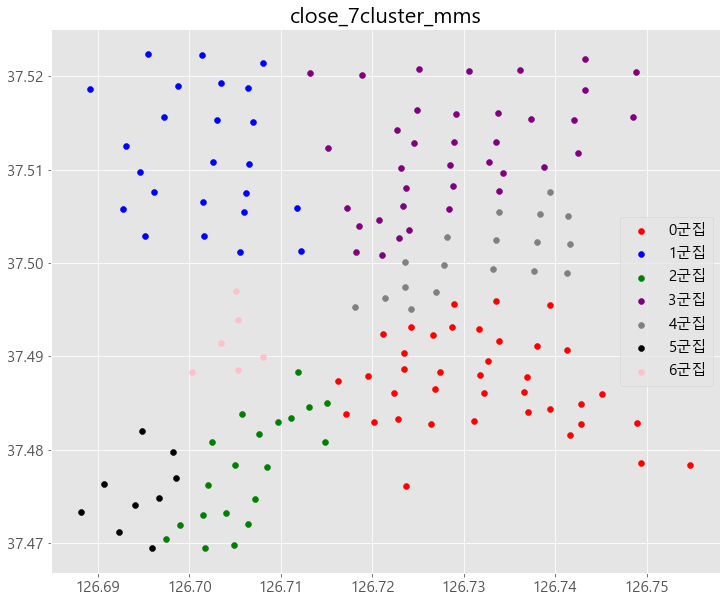

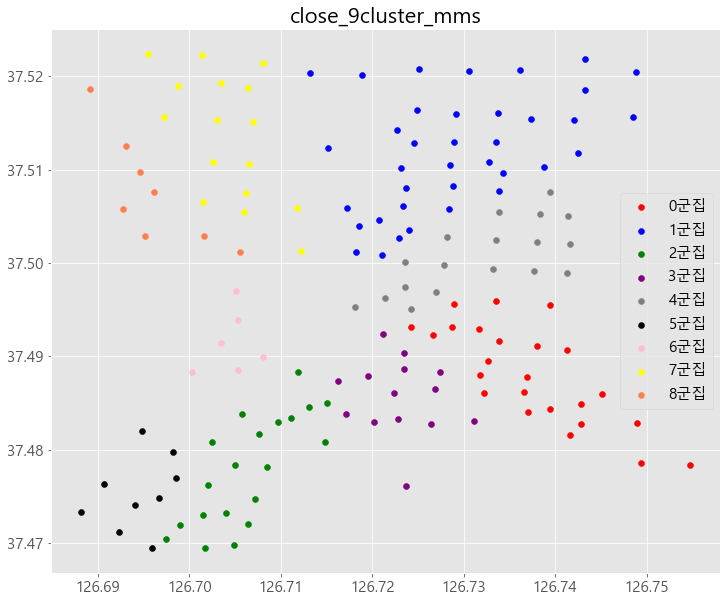

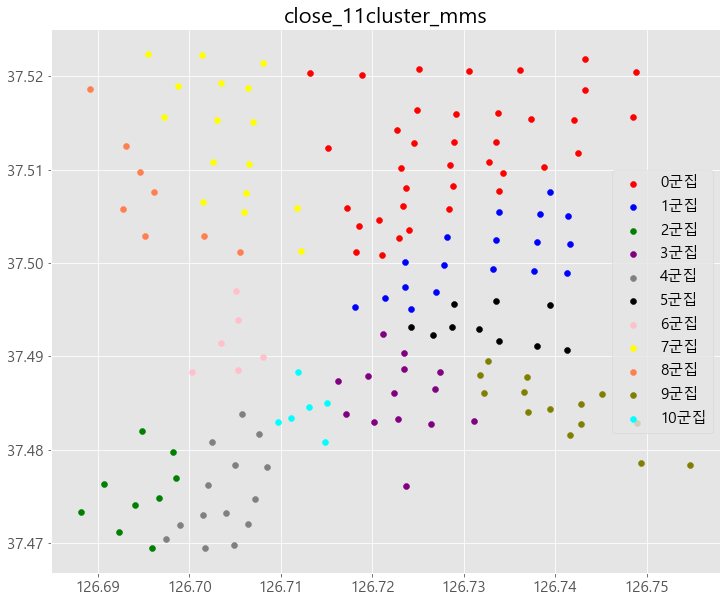

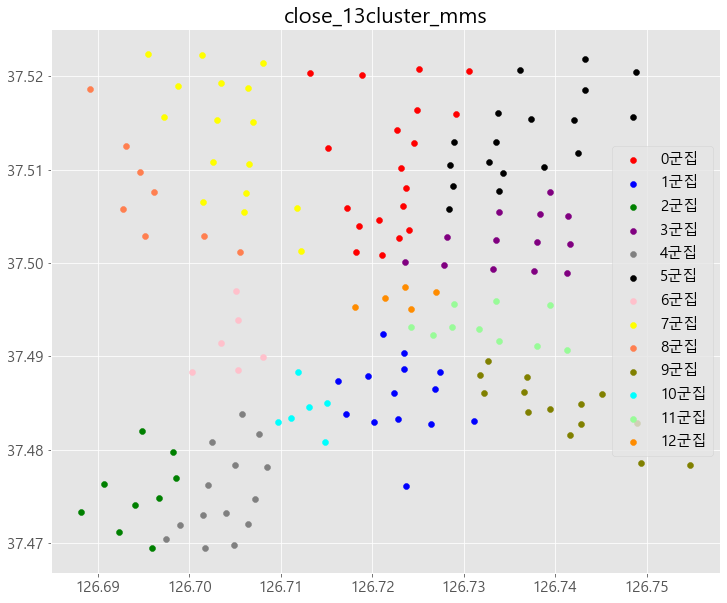

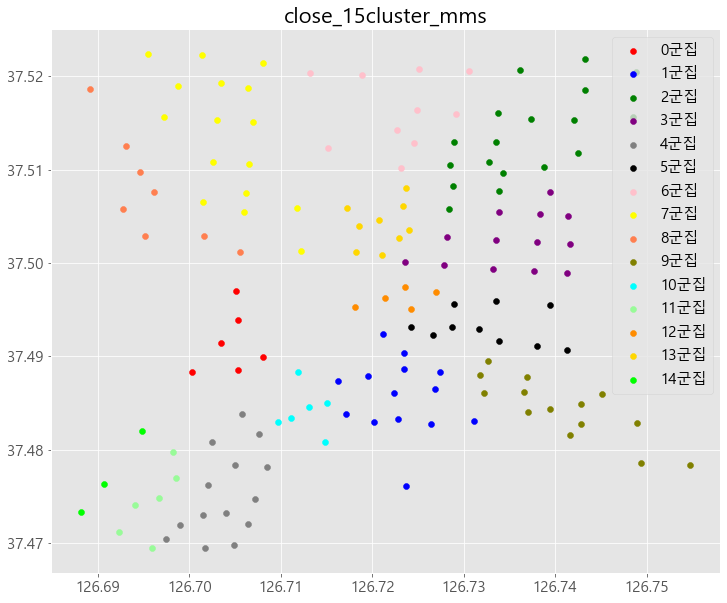

In [23]:
cluster_list = [7,9,11,13]
color_list = ['red','blue','green','purple','grey','black','pink','yellow',
              'coral','olive','aqua','palegreen','darkorange','gold','lime']
def iter_num(value):
    if value%5==1: return 7
    elif value%5==2: return 9
    elif value%5==3: return 11
    elif value%5==4: return 13
    elif value%5==0: return 15
    else: None

for i in range(1,11):
    col_name = mms_cluster.iloc[:,i].name 
    plt.title(col_name)
    for j in range(0,iter_num(i)):
        temp = mms_cluster.loc[mms_cluster[col_name]==j]
        plt.scatter(temp['x'],temp['y'],color=color_list[j],label=str(j)+'군집')
    plt.legend()
    plt.show()

## 2.3. Std 스케일 군집 시각화

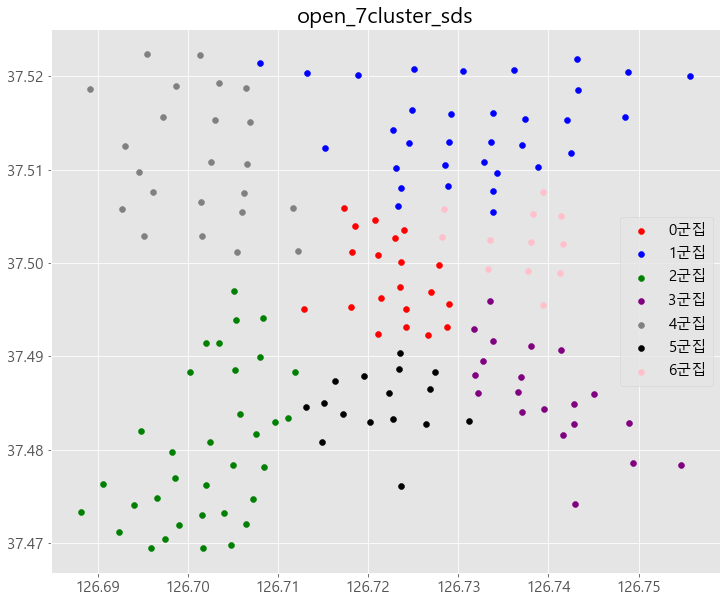

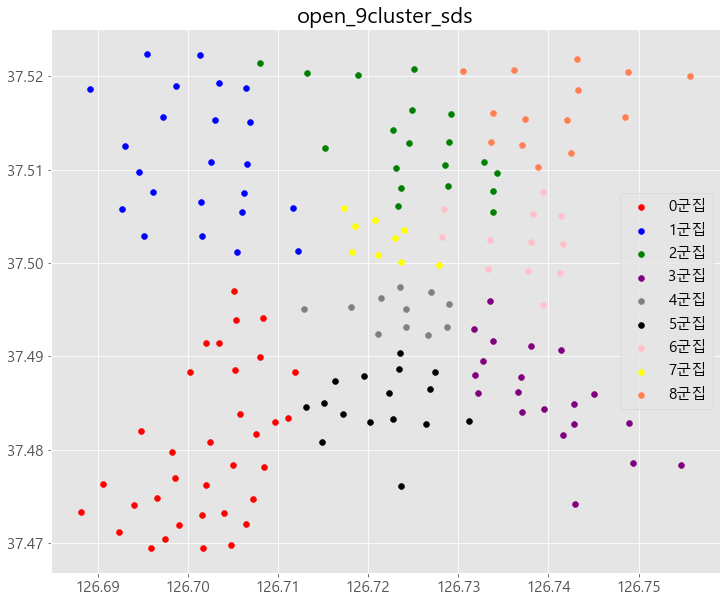

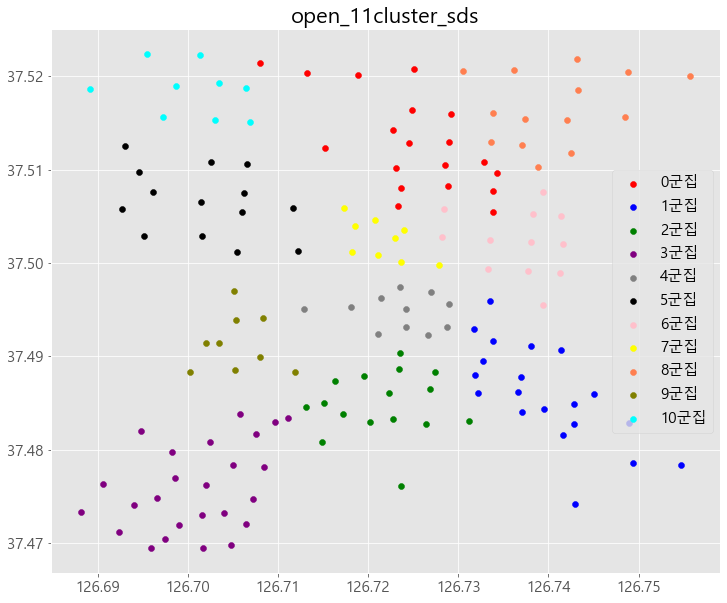

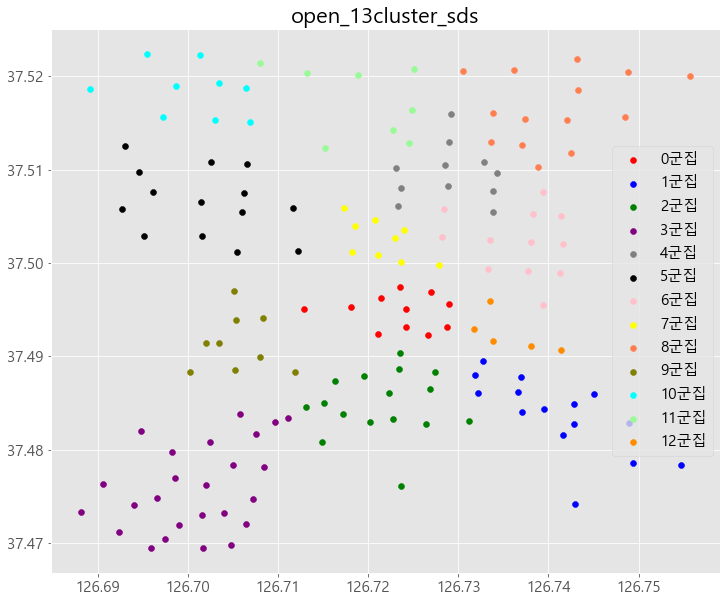

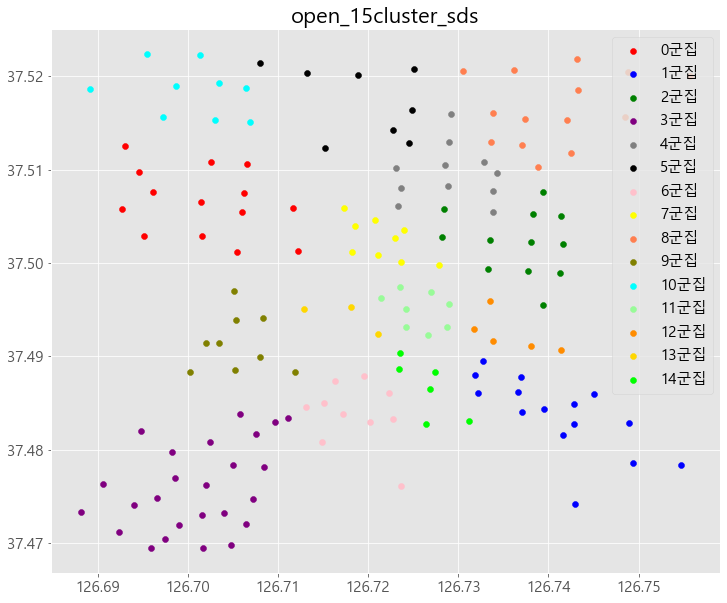

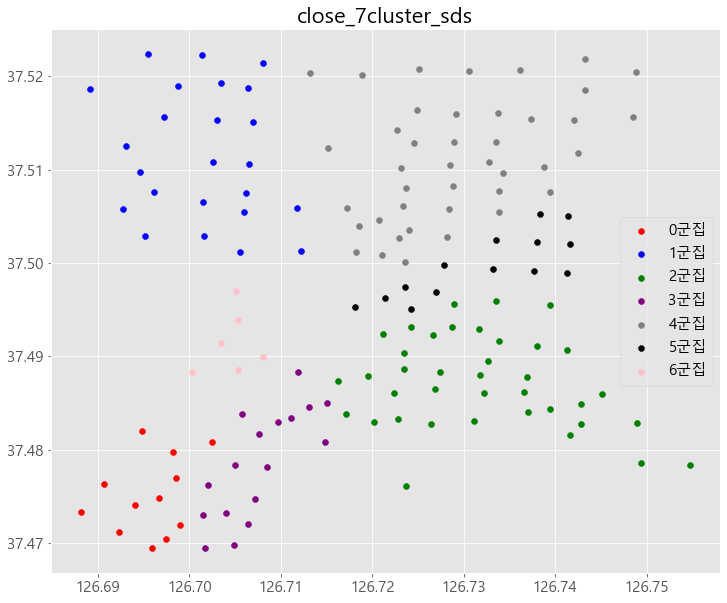

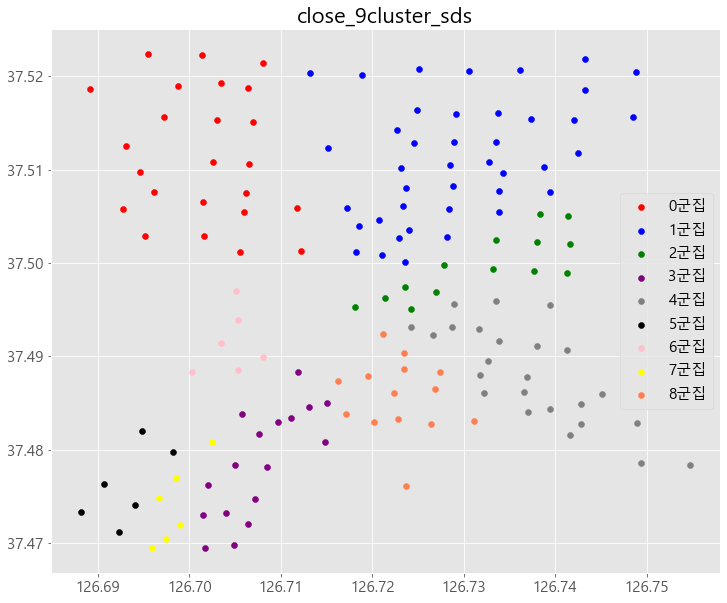

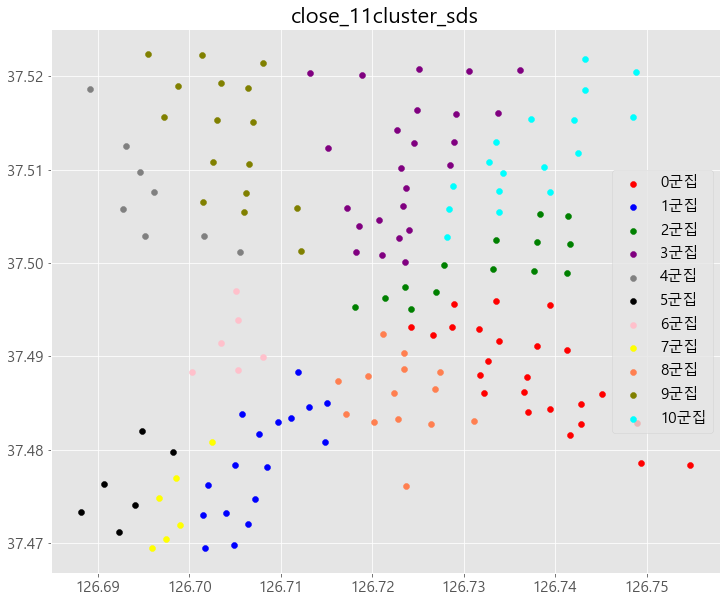

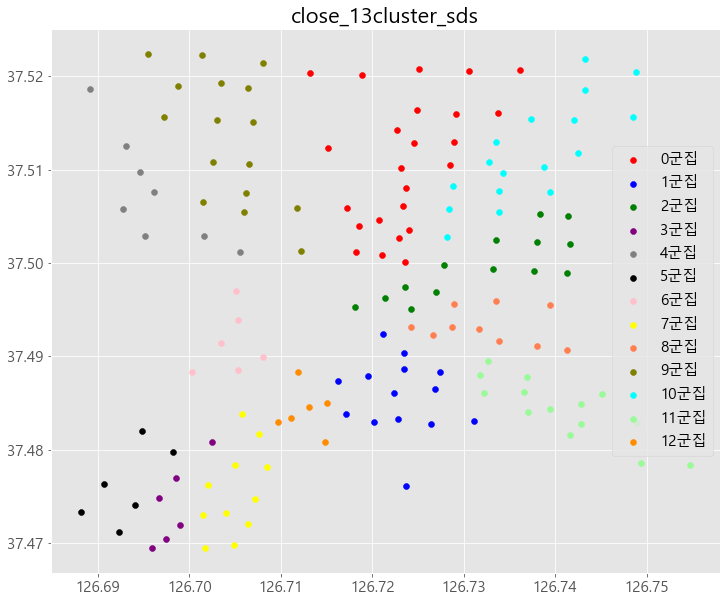

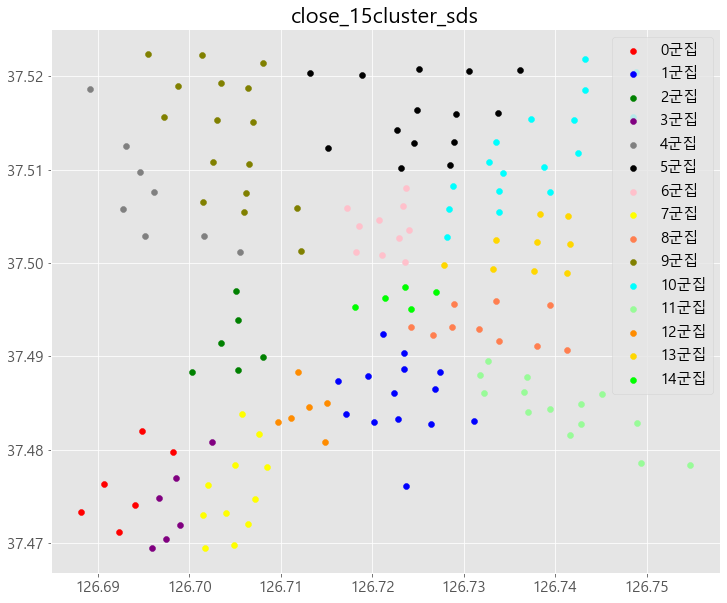

In [24]:
cluster_list = [7,9,11,13]
color_list = ['red','blue','green','purple','grey','black','pink','yellow',
              'coral','olive','aqua','palegreen','darkorange','gold','lime']
def iter_num(value):
    if value%5==1: return 7
    elif value%5==2: return 9
    elif value%5==3: return 11
    elif value%5==4: return 13
    elif value%5==0: return 15
    else: None

for i in range(1,11):
    col_name = sds_cluster.iloc[:,i].name 
    plt.title(col_name)
    for j in range(0,iter_num(i)):
        temp = sds_cluster.loc[sds_cluster[col_name]==j]
        plt.scatter(temp['x'],temp['y'],color=color_list[j],label=str(j)+'군집')
    plt.legend()
    plt.show()